In this notebook, we illustrate the python implementation of semi supervised anomaly detection framework for big unlabelled data. Our objective is to detect anomalies in an unlabelled data set $X_{m,r}$ with $m$ rows and $r$ numerical features. The following figure exhibits the anomaly detection architecture in a nutshell.

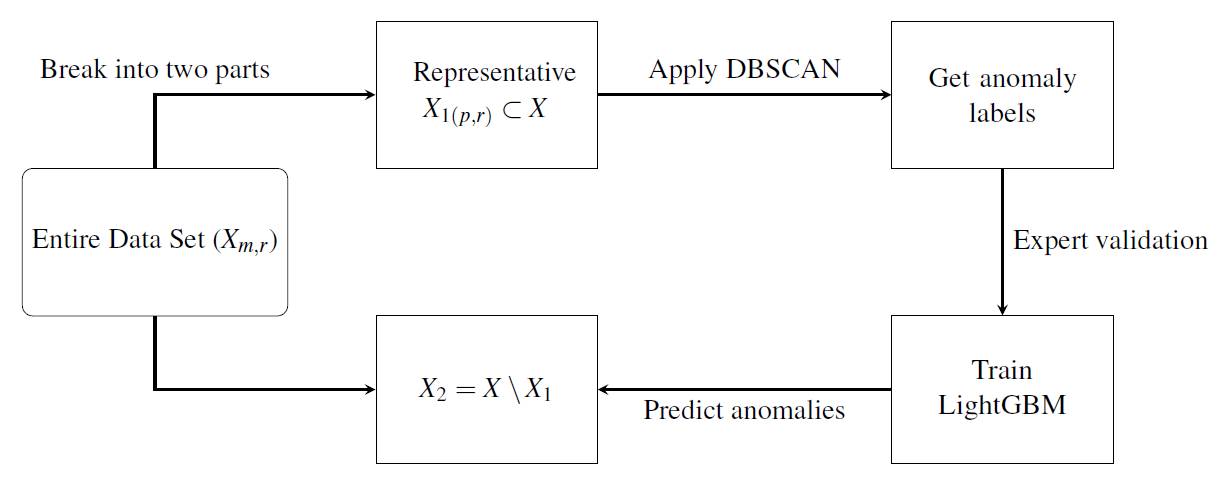

First, we import all the essential libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors

import time
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

Next, a representative subset ($X_1$) of $p$ observations is sampled from the dataset $X$ as: $X_{1 (p,r)} \subset X$ and we define $X_{2 (m-p,r)}$ as $X_2 = X\setminus X_1$, where $p<<m$. We perform this by predefining the sampling fraction as $frac = p/m$.

In [2]:
def rep_sample(X, frac):
    X1 = X.sample(int(len(X)*frac))
    df_one[~df_one.index.isin(df_two.index)]
    X2 = X[~X.index.isin(X1.index)]
    return(X1,X2)

Representativeness of $X_1$ with respect to $X$ is validated by Kolmogorov-Smirnov two-sample test as follows: 

In [3]:
def representative_check(X,X1):
    counter = 0
    for col in X.columns:
        if ks_2samp(X1[col], X[col]).pvalue > 0.05:
            counter = counter + 1
    if counter == X.shape[1]:
        print("Sample is representative")
    else: print("Sample is not representative, try sampling again")       

Once the representative subset $X_1$ is sampled, we apply DBSCAN algorithm to detect anomalies on $X_1$. Before applying DBSCAN, we scale $X_1$ using min-max scaler. 

In [4]:
def scale(X1):
    df_num = MinMaxScaler().fit_transform(X1)
    return(df_num)

Now, we need to optimize parameters of DBSCAN. MinPts (min_samples parameter in DBSCAN function) is set as $2r$ and the optimal value of $\epsilon$ is obtained by using $k$-nearest neighbor plot. We use Euclidean distance as our distance metric.

In [5]:
def plot_optimal_eps(df_num):
    
    start_time = time.time()
    
    neigh = NearestNeighbors(n_neighbors=2*pd.DataFrame(df_num).shape[1])
    nbrs = neigh.fit(df_num)
    distances, indices = nbrs.kneighbors(df_num)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    
    plt.plot(distances)
    plt.xlabel("Points sorted by average distance of nearest neighbours")
    plt.ylabel("Average distance of "+str(2*pd.DataFrame(df_num).shape[1])+" nearest neighbours")
    plt.show()
    
    end_time = time.time()
    
    print("time taken for optimizing epsilon in DBSCAN is " , end_time - start_time , "seconds")

Optimal $\epsilon$ value is set to be the distance value which corresponds to the point where the sharpness in the plot is observed.
Our next step is to apply DBSCAN on the smaller subset using the optimal parameters and generate pseudo-labels.

In [6]:
def pseudo_labels(df_num, opt_eps):
    
    start_time = time.time()
    
    db = DBSCAN(eps = opt_eps, min_samples = 2*X.shape[1]).fit(df_num)
    labels = db.labels_
    
    end_time = time.time()
    print("time taken for this dbscan is " , end_time - start_time , "seconds")
    
    return(labels)

It is necessary to investigate whether data contains collective anomalies. This can be examined by taking a peek at the frequency distribution of the labels.

In [7]:
def freq_labels(labels):
    unique, counts = np.unique(labels, return_counts=True)
    print (np.asarray((unique, counts)).T)

Next the pseudo labells are attached into the smaller subset of the data, so that expert validation becomes easier and we create our training data for our classifier LightGBM

In [8]:
def create_train(X1,labels):
    X1["labels"] = labels
    X1['target'] = np.where(X1['labels']==0 , 0 , 1)
    del X1["labels"]
    gc.collect()
    return(X1)

Once, the expert validation of anomalous observations is complete, we train our LightGBM model using 5 folds. LightGBM parameters can be found by optimizing out-of-fold ROC-AUC value. With a fixed set of parameters, we train and predict our LightGBM model on $X_1$ and $X_2$ respectively.

In [9]:
param = {         
    'bagging_fraction': 0.6,  
    'boost': 'gbdt',            
    'feature_fraction': 0.6,     
    'learning_rate': 0.1,
    'max_depth': -1,            
    'metric':'auc',               
    'min_data_in_leaf': 40,    
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 31,           
    'objective': 'binary',
    'verbosity': 1
}

In [10]:
def LightGBM_training(X1, N=5):
    kf = KFold(n_splits=N)
    y_train = X1['target'].copy()
    
    features = [c for c in X1.columns if c not in ['target']]
    
    folds = KFold(n_splits=N)
    
    oof = np.zeros(len(X1))
    predictions = np.zeros(len(X2))
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X1.values, y_train.values)):
        print("Fold {}".format(fold_))
        trn_data = lgb.Dataset(X1.iloc[trn_idx][features], label=y_train.iloc[trn_idx])
        val_data = lgb.Dataset(X1.iloc[val_idx][features], label=y_train.iloc[val_idx])
        clf = lgb.train(param, trn_data, 100, valid_sets = [trn_data, val_data], verbose_eval=20, early_stopping_rounds = 10)
        oof[val_idx] = clf.predict(X1.iloc[val_idx][features], num_iteration=clf.best_iteration)
        predictions += clf.predict(X2[features], num_iteration=clf.best_iteration) / folds.n_splits
        
        feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),features)), columns=['Value','Feature'])
        plt.figure(figsize=(12, 8))
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
        plt.title('LightGBM Features')
        plt.tight_layout()
        plt.show()
        
    return(oof, predictions)